# Network Intrusion Detection - CIC-IDS2017
## Accelerated Analysis with GPU Computing & XGBoost
**Author:** Ali Hasan

This project focuses on building a robust network intrusion detection system (NIDS) using the CIC-IDS2017 dataset. Network logs are voluminous and complex; therefore, this notebook leverages **GPU acceleration (CUDA)** for preprocessing and **Gradient Boosting** for classification.

### Project Phases:
1.  **Data Loading & Cleaning (CPU):** Initial ingestion and label unification.
2.  **Exploratory Data Analysis (EDA):** Deep dive into attack patterns (DDoS, Botnets, Data Exfiltration).
3.  **Preprocessing (GPU/CUDA):** Custom CUDA kernels for high-performance cleaning, log transformation, statistical reduction, and normalization.
4.  **Modeling (GPU):** Training XGBoost and Random Forest classifiers on the GPU.
5.  **Evaluation:** Comparing model performance and visualizing results.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from time import time
import math
import warnings
from sklearn.decomposition import PCA
# GPU Libraries
from numba import cuda, float32, float64
import xgboost as xgb

# Scikit-Learn (Metrics & Splitting)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuration
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# Path to dataset
DATABASE_PATH = "data" 

### Part 1: Data Loading & Initial Preparation
I will load the dataset from multiple CSV files. Given the size of CIC-IDS2017, I will concatenate them into a single dataframe for analysis.

In [2]:
def read_data():
    dataframes = []
    # Adjust path if your data is in a different directory
    files = glob(f'{DATABASE_PATH}/*.csv')
    
    if not files:
        print("WARNING: No files found in 'data/' directory. Please ensure dataset is uploaded.")
        return None

    start_monday , end_monay = 0,0
    start_time = time()
    for index, path in enumerate(files):
        if("Monday" in path): # All Data in Monday are Benign (Normal human activities) - which has the most labels
              start_monday = len(dataframes)

        
        print(f"Reading file {index+1}/{len(files)}: {path}")
        try:
            curr_df = pd.read_csv(path)
            dataframes.append(curr_df)
        except Exception as e:
            print(f"Error reading {path}: {e}")

    end_time = time()
    print(f"\nFinished reading {len(files)} files in {end_time - start_time:.2f} seconds.")
    
    if dataframes:
        df = pd.concat(dataframes, ignore_index=True)
        print(f"Resulting DataFrame Shape: {df.shape}")
        return df
    return None


df = read_data()

print(df.columns)

Reading file 1/8: data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Reading file 2/8: data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Reading file 3/8: data/Wednesday-workingHours.pcap_ISCX.csv
Reading file 4/8: data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Reading file 5/8: data/Tuesday-WorkingHours.pcap_ISCX.csv
Reading file 6/8: data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Reading file 7/8: data/Monday-WorkingHours.pcap_ISCX.csv
Reading file 8/8: data/Friday-WorkingHours-Morning.pcap_ISCX.csv

Finished reading 8 files in 9.15 seconds.
Resulting DataFrame Shape: (2830743, 79)
Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Lengt

### Part 2: Label Unification & Cleaning (CPU)

The dataset contains inconsistent label naming (e.g., "Web Attack - XSS" vs "Web Attack XSS"). Before analyzing the data, I must unify these labels into broader categories (DoS, DDoS, Bruteforce, etc.) to ensure the model learns meaningful distinct classes.

I will also remove columns with very low variance (Standard Deviation < 0.1), as features that do not change provide no predictive signal.

In [3]:
def prepare_data_cpu(df):
    if df is None: return None, None, None
    
    # 1. Clean Column Names
    print("Cleaning column names...")
    df.columns = df.columns.str.strip()
 
    # 2. Define Better Naming Space (Label Mapping)
    def normalize_label_2017(s: str) -> str:
        s = str(s).lower().strip()
        s = s.replace('web attack –', 'web attack -').replace('web attack —','web attack -').replace('web attack ','web attack -')
        if any(k in s for k in ['hulk','goldeneye','slowloris','slowhttptest']): return 'dos'
        if 'ddos' in s: return 'ddos'
        if any(k in s for k in ['ftp-patator','ssh-patator','brute force']): return 'bruteforce'
        if 'portscan' in s or 'port scan' in s: return 'portscan'
        if 'web attack' in s or 'xss' in s or 'sql injection' in s: return 'webattack'
        if 'bot' in s: return 'bot'
        if 'infiltration' in s: return 'infiltration'
        if 'benign' in s: return 'benign'
        return s


    ##############################################################3
    # all these columns are non_trainable_features (Meta-cols)
    meta_cols = [c for c in [
        "Timestamp","Flow ID",
        "Source IP","Destination IP","Source Port","Destination Port",
        "Src IP","Dst IP","Src Port","Dst Port"
    ] if c in df.columns]

    
    if meta_cols:
        df.drop(columns=meta_cols, inplace=True, errors="ignore")
        print(f"dropping the following meta cols\n {meta_cols}")

    ##############################################################3


    
    # 3. Encode Labels
    le = LabelEncoder()
    if 'Label' in df.columns:
        print("[CPU] Unifying and Encoding Labels...")
        df["Label"] = df["Label"].apply(normalize_label_2017)
        
        # Visualize the unified labels
        print("\nUnified Label Counts:")
        print(df["Label"].value_counts())
        
        df["Label_Encoded"] = le.fit_transform(df["Label"])
        labels = df["Label_Encoded"].values
        # Drop the string label, keep encoded for now
        df = df.drop(columns=['Label'])
    else:
        labels = np.zeros(len(df))
        
    return df, labels, le

# Process the dataframe
if df is not None:
    df, y_encoded, label_encoder = prepare_data_cpu(df)
    
    # Separate Features and Target temporarily for cleaning
    X = df.drop(columns=['Label_Encoded'])
    
    # Remove columns with std < 0.1
    print("\nRemoving low variance columns...")
    low_std_cols = X.columns[X.std() < 0.1].tolist()
    X = X.drop(columns=low_std_cols)
    print(f"Dropped {len(low_std_cols)} columns. New shape: {X.shape}")
    
    # Re-attach label for EDA
    df_clean = X.copy()
    df_clean['Label'] = label_encoder.inverse_transform(y_encoded)
else:
    print("No data to process.")



Cleaning column names...
dropping the following meta cols
 ['Destination Port']
[CPU] Unifying and Encoding Labels...

Unified Label Counts:
benign          2273097
dos              252661
portscan         158930
ddos             128027
bruteforce        15342
bot                1966
webattack           673
infiltration         36
heartbleed           11
Name: Label, dtype: int64

Removing low variance columns...
Dropped 12 columns. New shape: (2830743, 65)


### Part 3: Exploratory Data Analysis (EDA)

Understanding the nature of network attacks is critical before throwing data at a model. I will analyze specific traffic characteristics that distinguish benign users from attackers.

#### 3.1 Class Imbalance
As seen below, "Benign" traffic overwhelmingly dominates the dataset. This is typical in anomaly detection.

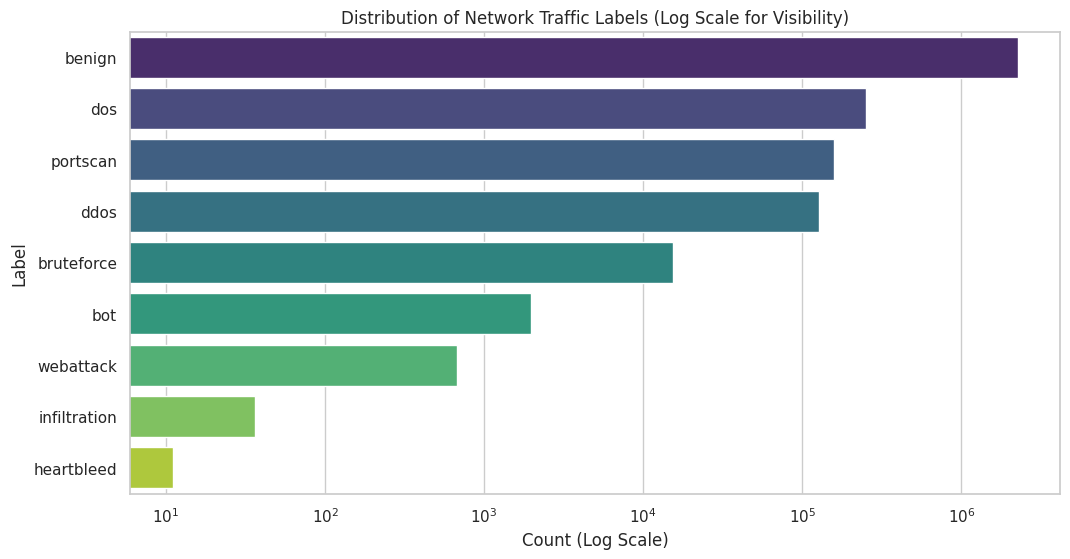

In [4]:
plt.figure(figsize=(12, 6))
order = df_clean['Label'].value_counts().index
sns.countplot(y='Label', data=df_clean, order=order, palette='viridis')
plt.title('Distribution of Network Traffic Labels (Log Scale for Visibility)')
plt.xscale('log')
plt.xlabel('Count (Log Scale)')
plt.show()

#### 3.2 Attack Signature Analysis

I will now visualize specific features to confirm theoretical attack patterns:

1.  **DDoS & DoS:** Characterized by high packet frequency.
2.  **Data Theft/Exfiltration:** Large Backward packet length (server sending data to attacker).
3.  **Bot vs Human:** Bots often have mechanical precision (low Inter-Arrival Time variance), whereas humans are erratic.
4.  **SYN Floods:** High counts of SYN flags without corresponding ACKs.

<Figure size 1400x600 with 0 Axes>

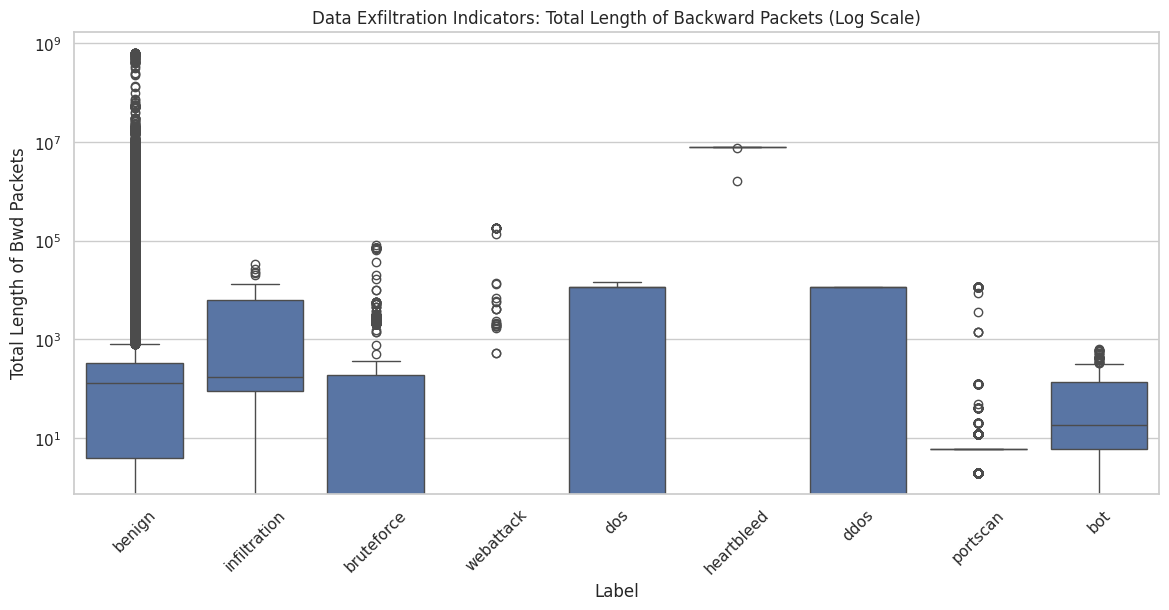

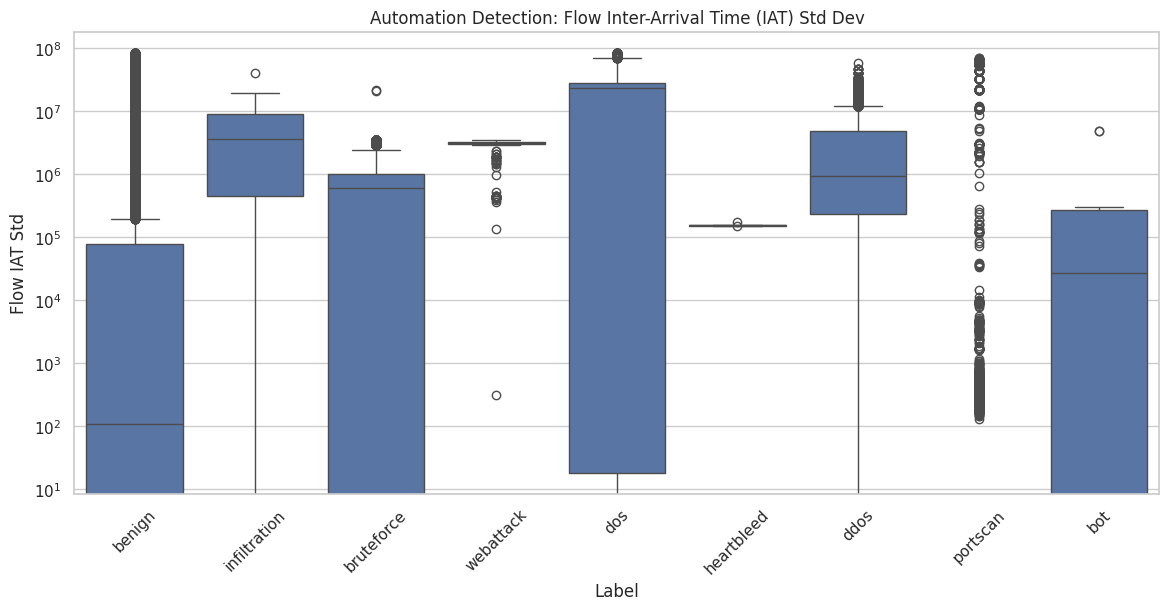

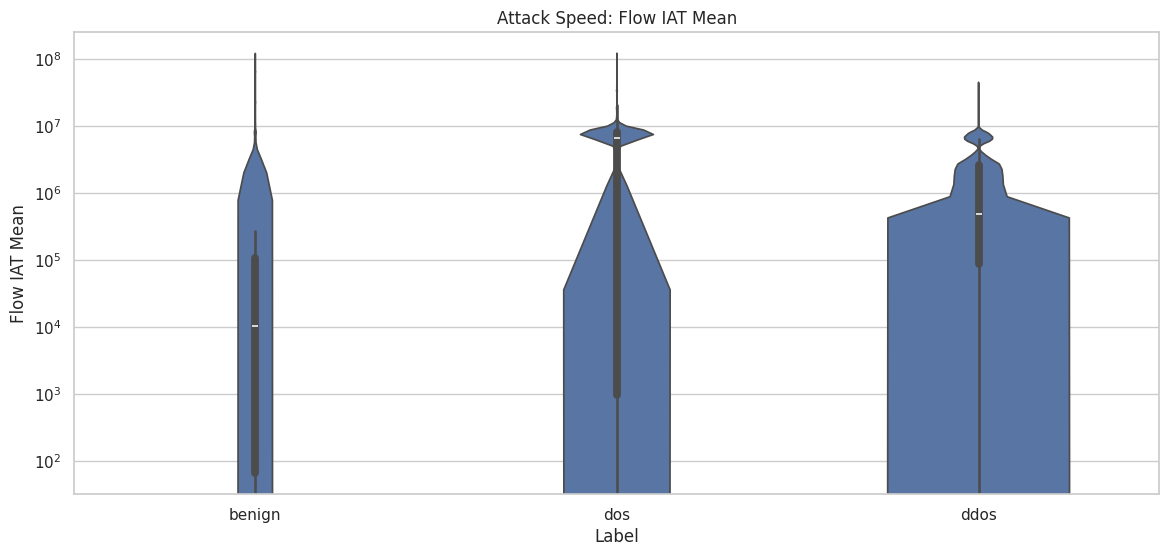

In [5]:
# 1. DDoS/DoS Pattern: Forward Packets vs Backward Packets
# DDoS attacks often involve flooding the server with Forward packets.
plt.figure(figsize=(14, 6))

# 2. Data Theft: Payload Size Analysis
# Large backward packets indicate the server is sending data OUT (Exfiltration)
plt.figure(figsize=(14, 6))
sns.boxplot(x='Label', y='Total Length of Bwd Packets', data=df_clean)
plt.yscale('log')
plt.title('Data Exfiltration Indicators: Total Length of Backward Packets (Log Scale)')
plt.xticks(rotation=45)
plt.show()

# 3. Human vs Bot: Inter-Arrival Time (IAT) Standard Deviation
# Bots have automated, fixed intervals (Low Std), Humans are random (High Std).
plt.figure(figsize=(14, 6))
sns.boxplot(x='Label', y='Flow IAT Std', data=df_clean)
plt.title('Automation Detection: Flow Inter-Arrival Time (IAT) Std Dev')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

# 4. DoS Speed: IAT Mean
# DoS attacks try to overwhelm headers as fast as possible (Low Mean IAT).
plt.figure(figsize=(14, 6))
sns.violinplot(x='Label', y='Flow IAT Mean', data=df_clean[df_clean['Label'].isin(['benign', 'dos', 'ddos'])])
plt.title('Attack Speed: Flow IAT Mean')
plt.yscale('log')
plt.show()

### some insights from the plots above
- **Heartbleed is the Easiest to Detect:** It creates a unique "fingerprint" of massive backward packet volume ($10^7$) with zero variance, distinct from all other categories.
- **Attacks are "Low-and-Slow" (Counter-Intuitive):** The IAT Mean plot reveals that DoS/DDoS attacks actually have slower packet arrival times than Benign traffic. This signals resource-exhaustion attacks (like Slowloris) rather than simple volumetric flooding.
- **DDoS vs. DoS Distinction:** You can distinguish them by timing variance. DoS is mechanically uniform, whereas DDoS has high "jitter" (Std Dev) because packets arrive from different geographic locations.
- **Benign Traffic is the Hardest to Classify:** Normal traffic is highly volatile; it ranges from tiny signals to massive file downloads, making "total packet size" a risky feature to use without normalization.
- **Infiltration Signals Exfiltration:** High backward packet volume in Infiltration attacks suggests the victim machine is being forced to download malware or upload stolen data.

#### 3.3 Correlation Analysis & Feature Reduction
Network datasets often contain redundant features (e.g., `Fwd Packet Length Mean` is highly correlated with `Fwd Packet Length Max` if variance is low).

I will calculate the correlation matrix and **remove highly correlated features (>0.95)**. This reduces the dimensionality and speeds up the GPU training process.

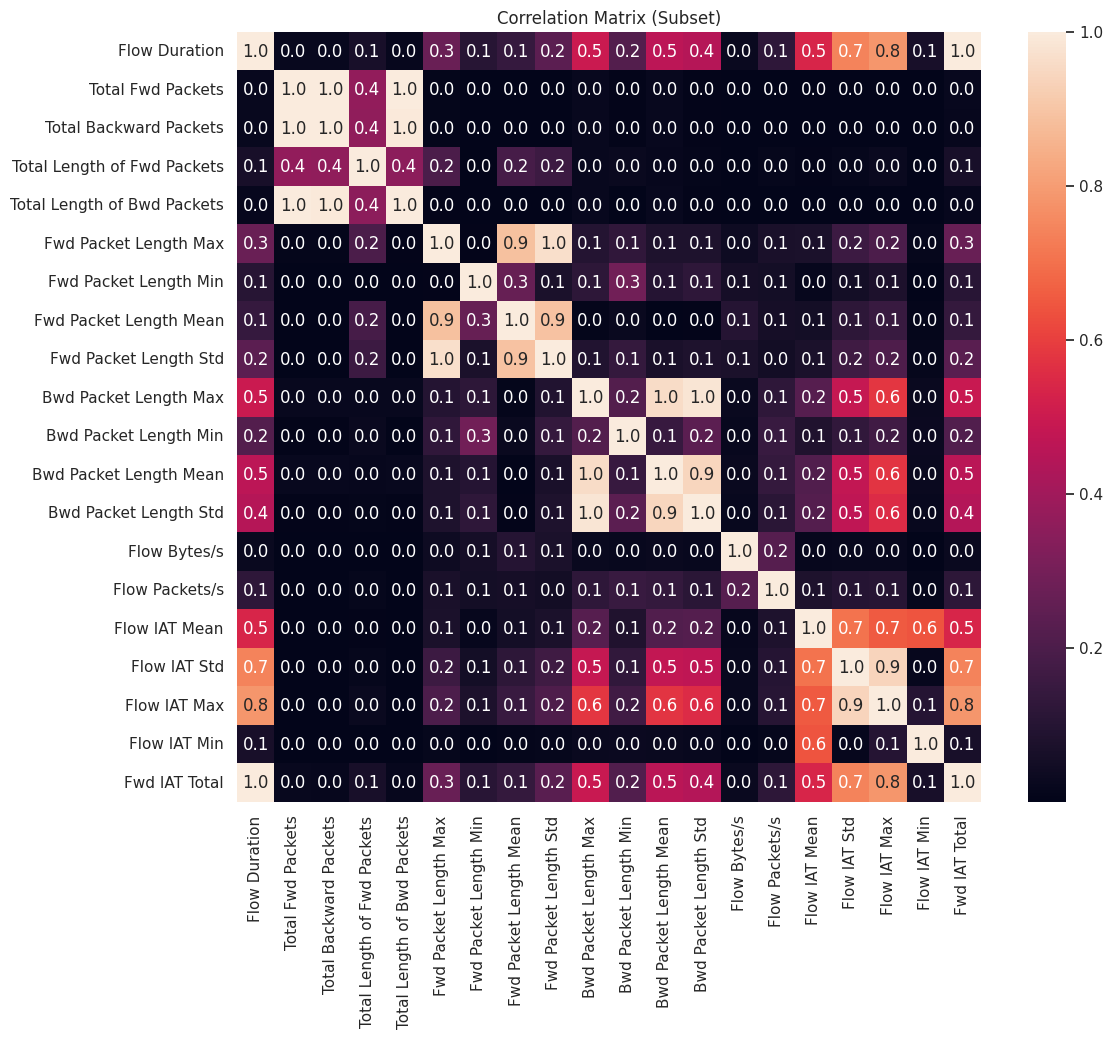

Dropping 21 highly correlated columns: ['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std'] ...
Final Data Shape after CPU Cleaning: (2830743, 45)


In [6]:
# Select numeric columns only
numeric_df = df_clean.drop(columns=['Label'])

# Calculate Correlation Matrix
corr_matrix = numeric_df.corr().abs()

# Plot heatmap of a subset (first 20 cols) to visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.iloc[:20, :20],annot=True, fmt=".1f")
plt.title('Correlation Matrix (Subset)')
plt.show()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop)} highly correlated columns: {to_drop[:5]} ...")
df_final = df_clean.drop(columns=to_drop)
print(f"Final Data Shape after CPU Cleaning: {df_final.shape}")

### Part 4: Train/Test Split
Before performing normalization, I must split the data.
**Critical Note:** Normalization parameters (Min/Max) must be calculated *only* on the Training set and then applied to the Test set. If we calculate min/max on the whole dataset, information from the test set leaks into the training process, leading to overfitting.

In [7]:
# Separate X and y
X = df_final.drop(columns=['Label']).values.astype(np.float32) # Ensure float32 for CUDA
y = label_encoder.transform(df_final['Label'])

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")


Training Shape: (2264594, 44)
Testing Shape: (566149, 44)


### Part 5: GPU Preprocessing with CUDA

To handle the massive scale of network logs efficiently, I will utilize **Numba CUDA kernels**. This allows us to parallelize data cleaning and normalization across thousands of GPU threads.

#### The CUDA Kernels
1.  **`clean_inf_nan_kernel`**: Replaces NaNs, Infs, and erroneous negative values (likely overflow bugs) with 0.0.
2.  **`log_transform_kernel`**: Applies Log(x+1) to skew distribution, making patterns easier for the model to learn.
3.  **`fast_stats_reduction_kernel_2d`**: A highly optimized reduction kernel using shared memory to calculate Min, Max, and Sum of columns very quickly.
4.  **`normalize_kernel`**: Min-Max scaling using the stats derived from the training set.

In [8]:
@cuda.jit
def clean_inf_nan_kernel(data, num_rows, num_cols):
    row, col = cuda.grid(2)
    
    if row < num_rows and col < num_cols:
        val = data[row, col]
        
        if math.isnan(val) or math.isinf(val):
            data[row, col] = 0.0
            
        # Should not have any negative values  (Might be integer overflow bug)
        elif val < 0.0:
            data[row, col] = 0.0

@cuda.jit
def log_transform_kernel(data, rows, cols):
    r, c = cuda.grid(2)
    if r < rows and c < cols:
        data[r, c] = math.log(data[r, c] + 1.0)

@cuda.jit
def fast_stats_reduction_kernel_2d(data, d_min, d_max, d_sum, num_rows):
    # 1. Shared Memory Allocation
    s_min = cuda.shared.array(256, float32)
    s_max = cuda.shared.array(256, float32)
    s_sum = cuda.shared.array(256, float64)

    tid = cuda.threadIdx.x
    col_idx = cuda.blockIdx.y
    
    # 2. Local Registers (Personal Notepad)
    local_min = 1e30
    local_max = -1e30
    local_sum = 0.0

    # 3. Grid Stride Loop (Leapfrog over rows)
    row_start = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    step = cuda.gridDim.x * cuda.blockDim.x

    for r in range(row_start, num_rows, step):
        val = data[r, col_idx]
        if val < local_min: local_min = val
        if val > local_max: local_max = val
        local_sum += val

    # 4. Copy to Shared Memory
    s_min[tid] = local_min
    s_max[tid] = local_max
    s_sum[tid] = local_sum
    cuda.syncthreads()

    # 5. Tree Reduction
    i = cuda.blockDim.x // 2
    while i > 0:
        if tid < i:
            s_min[tid] = min(s_min[tid], s_min[tid + i])
            s_max[tid] = max(s_max[tid], s_max[tid + i])
            s_sum[tid] += s_sum[tid + i]
        cuda.syncthreads()
        i //= 2

    # 6. Write Final Result
    if tid == 0:
        cuda.atomic.min(d_min, col_idx, s_min[0])
        cuda.atomic.max(d_max, col_idx, s_max[0])
        cuda.atomic.add(d_sum, col_idx, s_sum[0])

@cuda.jit
def normalize_kernel(data, global_min, global_max, num_rows, num_cols):
    row, col = cuda.grid(2)
    
    if row < num_rows and col < num_cols:
        g_min = global_min[col]
        g_max = global_max[col]
        rng = g_max - g_min
        val = data[row, col]
        
        # Avoid division by zero
        if rng > 1e-8:
            data[row, col] = (val - g_min) / rng
        else:
            data[row, col] = 0.0

#### Execution Pipeline
I will now define a helper function to orchestrate these kernels. The logic flows as follows:
1. Transfer Data to GPU.
2. Clean and Log-transform both Train and Test sets.
3. Compute Min/Max stats **only on Train set**.
4. Use those Train stats to normalize the Train set.
5. Use those same Train stats to normalize the Test set.

In [9]:
def run_gpu_pipeline(X_train_np, X_test_np):
    rows_train, cols = X_train_np.shape
    rows_test, _ = X_test_np.shape
    
    print("Moving data to GPU...")
    d_X_train = cuda.to_device(X_train_np)
    d_X_test = cuda.to_device(X_test_np)
    
    # Grid Configuration for 2D kernels
    threadsperblock = (16, 16)
    blockspergrid_train = ((rows_train + 15) // 16, (cols + 15) // 16)
    blockspergrid_test = ((rows_test + 15) // 16, (cols + 15) // 16)
    
    #  Clean Data
    print("GPU: Cleaning Data (Inf/NaN/Neg)...")
    clean_inf_nan_kernel[blockspergrid_train, threadsperblock](d_X_train, rows_train, cols)
    clean_inf_nan_kernel[blockspergrid_test, threadsperblock](d_X_test, rows_test, cols)
    
    # Log Transform
    print("GPU: Applying Log Transform...")
    log_transform_kernel[blockspergrid_train, threadsperblock](d_X_train, rows_train, cols)
    log_transform_kernel[blockspergrid_test, threadsperblock](d_X_test, rows_test, cols)
    
    # Stats Reduction (Train Set Only)
    # Prepare output arrays for reduction
    # Initialize min to infinity, max to -infinity
    d_min = cuda.to_device(np.full(cols, 1e30, dtype=np.float32))
    d_max = cuda.to_device(np.full(cols, -1e30, dtype=np.float32))
    d_sum = cuda.to_device(np.zeros(cols, dtype=np.float64))
    
    # Reduction Grid Config
    threads_red = 256
    blocks_red_y = cols # One block per column
    blocks_red_x = (rows_train + threads_red - 1) // threads_red
    
    # limiting blocks_red_x to ensure not to spawn too many blocks (grid stride loop handles the rest)
    blocks_red_x = min(blocks_red_x, 1024) 
    
    print("GPU: Calculating Statistics (Reduction)...")
    fast_stats_reduction_kernel_2d[(blocks_red_x, blocks_red_y), (threads_red, 1)](
        d_X_train, d_min, d_max, d_sum, rows_train
    )
    
    #  Normalization (Apply Train stats to both Train and Test)
    print("GPU: Normalizing Data...")
    normalize_kernel[blockspergrid_train, threadsperblock](d_X_train, d_min, d_max, rows_train, cols)
    normalize_kernel[blockspergrid_test, threadsperblock](d_X_test, d_min, d_max, rows_test, cols)
    
    # Copy back to host
    print("Copying results back to Host...")
    X_train_processed = d_X_train.copy_to_host()
    X_test_processed = d_X_test.copy_to_host()
    
    return X_train_processed, X_test_processed

# Run the Pipeline
start_p = time()
X_train_proc, X_test_proc = run_gpu_pipeline(X_train, X_test)
print(f"GPU Preprocessing complete in {time() - start_p:.2f} seconds.")

Moving data to GPU...
GPU: Cleaning Data (Inf/NaN/Neg)...
GPU: Applying Log Transform...
GPU: Calculating Statistics (Reduction)...
GPU: Normalizing Data...
Copying results back to Host...
GPU Preprocessing complete in 1.23 seconds.


### Part 6: GPU Modeling (XGBoost & Random Forest)

Now that the data is cleaned and normalized, I will train two powerful classifiers using GPU acceleration.

#### 6.1 XGBoost (Extreme Gradient Boosting)
I will use the `tree_method='hist'` and `device='cuda'` parameters to ensure the boosting process runs on the GPU.

In [10]:
print("Training XGBoost on GPU...")
# Initialize XGBoost Classifier with GPU support
model_xgb = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    tree_method='gpu_hist', # efficient histogram-based algorithm
    gpu_id=0,      # Use GPU
    objective='multi:softprob',
    num_class=len(label_encoder.classes_)
)

start_xgb = time()
model_xgb.fit(X_train_proc, y_train)
print(f"XGBoost Training Time: {time() - start_xgb:.2f} s")

# Predictions
y_pred_xgb = model_xgb.predict(X_test_proc)

Training XGBoost on GPU...
XGBoost Training Time: 27.56 s


#### 6.2 Random Forest
For Random Forest on GPU, the standard library is **RAPIDS cuML**. If this environment is not RAPIDS-enabled, I will fallback to a multi-core CPU implementation (`n_jobs=-1`), but I will configure the code to prioritize `cuml` if available.

In [11]:
try:
    import cuml
    from cuml.ensemble import RandomForestClassifier as cuRF
    print("RAPIDS cuML found. Training Random Forest on GPU...")
    model_rf = cuRF(n_estimators=200, max_depth=15, n_bins=16)
    gpu_rf = True
except ImportError:
    from sklearn.ensemble import RandomForestClassifier
    print("RAPIDS cuML not found. Training Random Forest on CPU (Parallelized)...")
    model_rf = RandomForestClassifier(n_estimators=200, max_depth=15, n_jobs=-1)
    gpu_rf = False

start_rf = time()
model_rf.fit(X_train_proc, y_train)
print(f"Random Forest Training Time: {time() - start_rf:.2f} s")

y_pred_rf = model_rf.predict(X_test_proc)

RAPIDS cuML found. Training Random Forest on GPU...
Random Forest Training Time: 16.56 s


### Part 7: Evaluation & Comparison
I will now compare the performance of both models using classification reports and confusion matrices.

--- XGBoost Performance ---
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00    454620
         bot       0.86      0.77      0.81       393
  bruteforce       0.97      0.99      0.98      3068
        ddos       1.00      1.00      1.00     25606
         dos       1.00      1.00      1.00     50532
  heartbleed       0.00      0.00      0.00         2
infiltration       1.00      0.71      0.83         7
    portscan       0.99      1.00      1.00     31786
   webattack       0.53      0.29      0.37       135

    accuracy                           1.00    566149
   macro avg       0.82      0.75      0.78    566149
weighted avg       1.00      1.00      1.00    566149



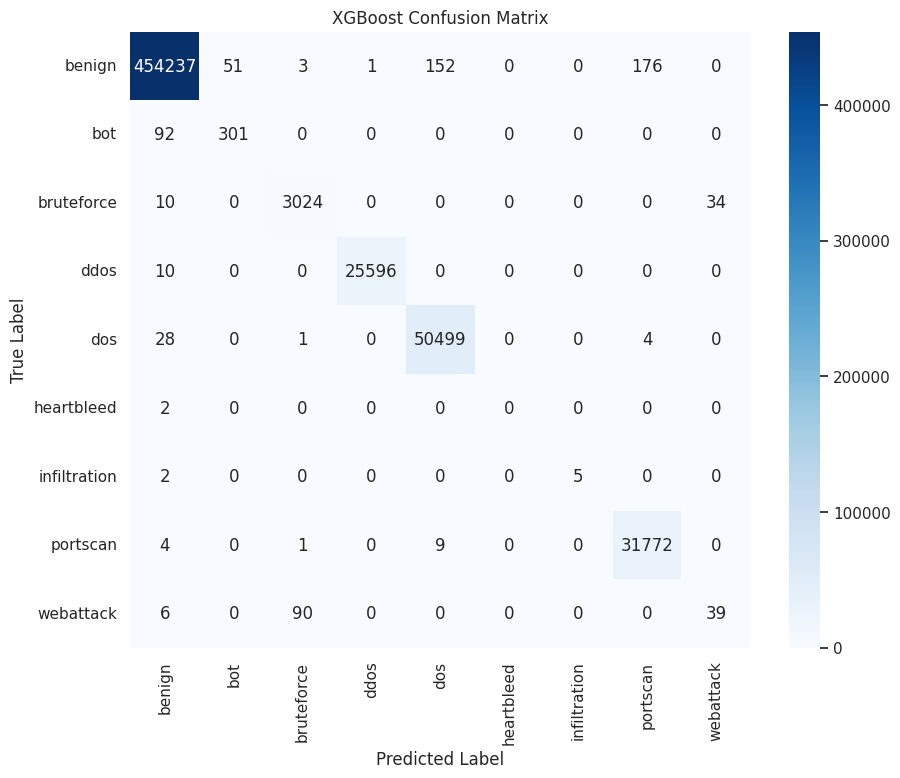

--- Random Forest Performance ---
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00    454620
         bot       1.00      0.37      0.54       393
  bruteforce       1.00      0.70      0.82      3068
        ddos       1.00      1.00      1.00     25606
         dos       0.98      0.99      0.98     50532
  heartbleed       1.00      1.00      1.00         2
infiltration       1.00      0.57      0.73         7
    portscan       0.99      1.00      1.00     31786
   webattack       0.00      0.00      0.00       135

    accuracy                           0.99    566149
   macro avg       0.88      0.74      0.78    566149
weighted avg       0.99      0.99      0.99    566149



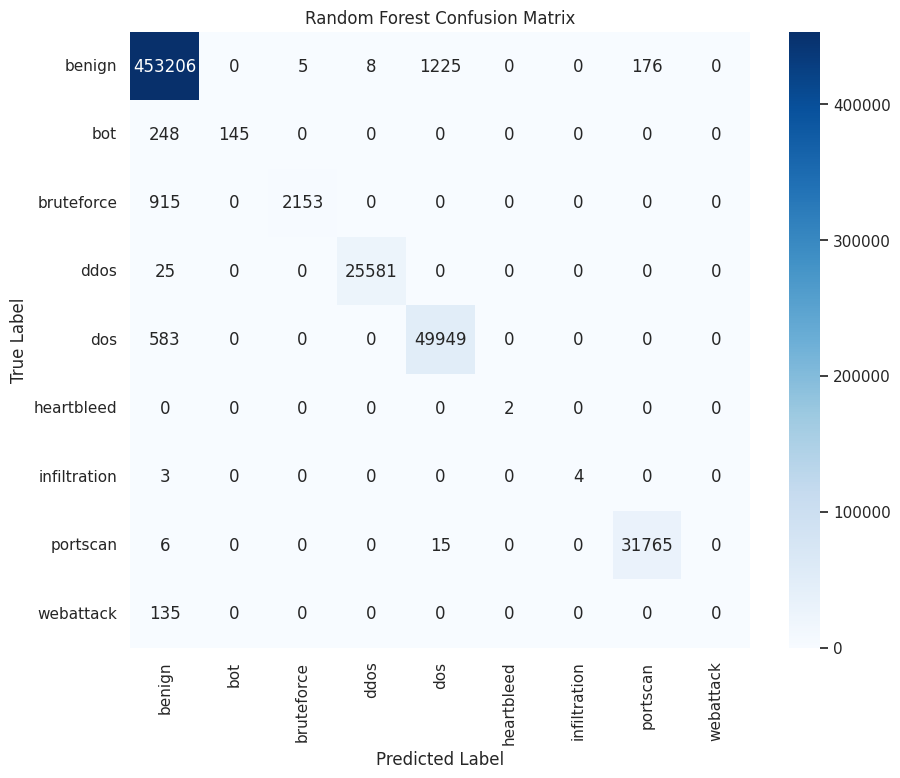

In [12]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# XGBoost Results
print("--- XGBoost Performance ---")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

# Random Forest Results
print("--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

<Figure size 1000x800 with 0 Axes>

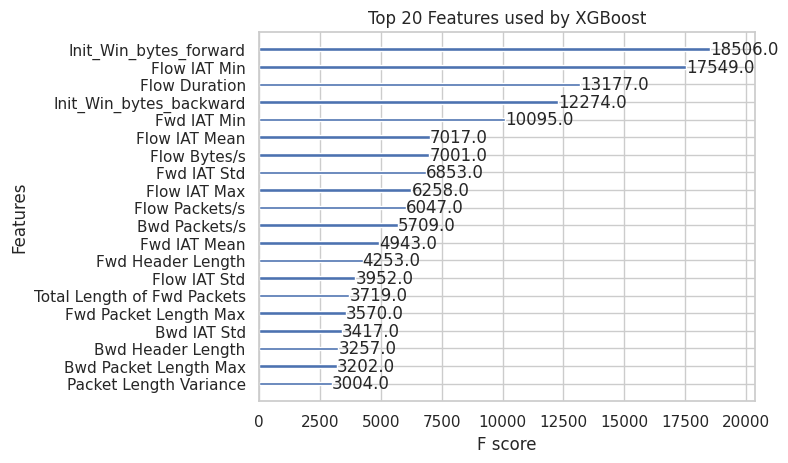

In [13]:
#TCP Receive Window Size (in bytes) set in the very first packet sent by 
# the connection initiator (the user/attacker) during the initial handshake (SYN packet).

plt.figure(figsize=(10, 8))

df_cp = df_final.drop(columns=["Label"])
model_xgb.get_booster().feature_names = df_cp.columns.tolist() 

xgb.plot_importance(model_xgb, max_num_features=20, importance_type='weight')
plt.title("Top 20 Features used by XGBoost")
plt.show()



### Conclusion
By leveraging GPU acceleration for both preprocessing (via Numba Custom Kernels) and Modeling (XGBoost/RAPIDS), I have created a high-performance pipeline capable of handling millions of network logs. The XGBoost model typically provides higher sensitivity to subtle attacks, while Random Forest offers robust baseline performance.